In [1]:
import os, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import seasonal_decompose


DATA_PATH = r"C:\Users\57484\Desktop\毕业设计 bristol\Dataset\Df_Amz_all.csv" 
GLOBAL_OUTPUT_DIR = r"C:\Users\57484\Desktop\毕业设计 bristol\eda_outputs"
SUBDIRS = [
    "plots/single_basin_ID31",
    "plots/all_basins",
    "tables"
]
mpl.rcParams['axes.labelweight'] = 'bold'  
mpl.rcParams['axes.labelsize'] = 12        
mpl.rcParams['xtick.labelsize'] = 10       
mpl.rcParams['ytick.labelsize'] = 10       
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.major.width'] = 1.2    
mpl.rcParams['ytick.major.width'] = 1.2   
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['font.weight'] = 'bold'       
    
for sd in SUBDIRS:
    os.makedirs(os.path.join(GLOBAL_OUTPUT_DIR, sd), exist_ok=True)


def savefig_to(subdir, filename, dpi=300):

    path = os.path.join(GLOBAL_OUTPUT_DIR, subdir, filename)
    os.makedirs(os.path.dirname(path), exist_ok=True)
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print("Saved ->", path)

In [2]:
df = pd.read_csv(DATA_PATH)

if "date" not in df.columns and "Date" in df.columns:
    df.rename(columns={"Date":"date"}, inplace=True)
df["date"] = pd.to_datetime(df["date"])

ALL_FEATURES = [
    "prec_ref","pet_pm","clim_tmin","clim_tmax","clim_pmm",
    "clim_petmm_day","aridity_index","q_mean_mm","runoff_coef",
    "baseflow_index","cover_urban_%","cover_crops_%",
    "res_number" , "hdisturb_index","catch_area","elev_mean",
    "catch_slope","catch_order"
]
TARGET = "Qmm"
ID_COL = "ID_CABra"

ALL_DYNAMIC = ["prec_ref", "pet_pm"]
ALL_STATIC  = [f for f in ALL_FEATURES if f not in ALL_DYNAMIC]

keep_cols = ["date", ID_COL] + ALL_FEATURES + [TARGET]
df = df[keep_cols]

BASIN_IDS = sorted(df[ID_COL].dropna().unique().tolist())

print("Rows:", len(df), "| Cols:", len(df.columns))
print("Basins:", len(BASIN_IDS), "| Example:", BASIN_IDS[:10])
df.head(3)


Rows: 164355 | Cols: 21
Basins: 15 | Example: [11, 21, 22, 30, 31, 32, 35, 37, 42, 44]


,date,ID_CABra,prec_ref,pet_pm,clim_tmin,clim_tmax,clim_pmm,clim_petmm_day,aridity_index,q_mean_mm,...,baseflow_index,cover_urban_%,cover_crops_%,res_number,hdisturb_index,catch_area,elev_mean,catch_slope,catch_order,Qmm
0,1980-10-01,11,0.062,5.049,23.03,32.55,5.4,5.29,0.98,2.5,...,87.21,0.002,0.058,1,0.0,49871.585,409.64,9.62,5,1.473862
1,1980-10-02,11,1.846,4.798,23.03,32.55,5.4,5.29,0.98,2.5,...,87.21,0.002,0.058,1,0.0,49871.585,409.64,9.62,5,1.773747
2,1980-10-03,11,0.041,5.446,23.03,32.55,5.4,5.29,0.98,2.5,...,87.21,0.002,0.058,1,0.0,49871.585,409.64,9.62,5,1.697334


In [3]:
#time 
date_min, date_max = df["date"].min(), df["date"].max()

# Column Statistics
desc = df[ [c for c in [TARGET] + ALL_FEATURES if c in df.columns] ].describe().T
desc["missing_rate"] = 1.0 - df[desc.index].notna().mean()
summary_info = pd.DataFrame({
    "date_min":[date_min], "date_max":[date_max],
    "n_rows":[len(df)], "n_basins":[len(BASIN_IDS)]
})

# save
desc.to_csv(os.path.join(GLOBAL_OUTPUT_DIR, "tables", "01_var_describe.csv"))
summary_info.to_csv(os.path.join(GLOBAL_OUTPUT_DIR, "tables", "00_dataset_overview.csv"), index=False)

print("Saved: tables/00_dataset_overview.csv & 01_var_describe.csv")
summary_info

Saved: tables/00_dataset_overview.csv & 01_var_describe.csv


,date_min,date_max,n_rows,n_basins
0,1980-10-01,2010-09-30,164355,15


In [4]:
desc

,count,mean,std,min,25%,50%,75%,max,missing_rate
Qmm,164355.0,2.028419,2.039903,0.000012,0.476109,1.302711,2.961126,22.145758,0.0
prec_ref,164355.0,6.057726,7.412047,0.000000,0.596000,3.561000,8.877000,97.025000,0.0
pet_pm,164355.0,3.870921,0.941658,1.098000,3.181000,3.828000,4.511000,7.997000,0.0
clim_tmin,164355.0,22.272667,1.107646,20.100000,21.310000,23.010000,23.160000,23.450000,0.0
clim_tmax,164355.0,31.906000,0.402391,31.360000,31.510000,32.040000,32.210000,32.550000,0.0
clim_pmm,164355.0,6.050667,0.625413,5.010000,5.750000,5.930000,6.360000,7.500000,0.0
clim_petmm_day,164355.0,5.408000,0.305139,4.940000,5.100000,5.410000,5.710000,5.740000,0.0
aridity_index,164355.0,0.901333,0.088534,0.770000,0.840000,0.880000,0.960000,1.080000,0.0
q_mean_mm,164355.0,2.027333,0.641224,0.730000,1.690000,2.130000,2.590000,2.970000,0.0
runoff_coef,164355.0,0.356667,0.094775,0.130000,0.290000,0.360000,0.430000,0.480000,0.0


### Temporal continuity and missing distribution

In [5]:
#Check date continuity gaps by basin 
def find_date_gaps(group, date_col="date"):
    g = group.sort_values(date_col)
    full = pd.DataFrame({"date": pd.date_range(g[date_col].min(), g[date_col].max(), freq="D")})
    merged = full.merge(g[[date_col]], on=date_col, how="left", indicator=True)
    missing_dates = merged.loc[merged["_merge"]=="left_only","date"]
    return pd.Series({
        "date_min": g[date_col].min(),
        "date_max": g[date_col].max(),
        "n_missing_days": int(missing_dates.shape[0])
    })

gap_table = df.groupby(ID_COL).apply(find_date_gaps).reset_index()
gap_table.to_csv(os.path.join(GLOBAL_OUTPUT_DIR, "tables", "02_date_gaps_per_basin.csv"), index=False)

# Missing rate (key columns)
key_cols = [TARGET] + ALL_DYNAMIC
miss_table = df.groupby(ID_COL)[key_cols].apply(lambda x: 1-x.notna().mean()).reset_index()
miss_table.columns = [ID_COL] + [f"miss_{c}" for c in key_cols]
miss_table.to_csv(os.path.join(GLOBAL_OUTPUT_DIR, "tables", "03_missing_rate_keycols_per_basin.csv"), index=False)

gap_table

,ID_CABra,date_min,date_max,n_missing_days
0,11,1980-10-01,2010-09-30,0
1,21,1980-10-01,2010-09-30,0
2,22,1980-10-01,2010-09-30,0
3,30,1980-10-01,2010-09-30,0
4,31,1980-10-01,2010-09-30,0
5,32,1980-10-01,2010-09-30,0
6,35,1980-10-01,2010-09-30,0
7,37,1980-10-01,2010-09-30,0
8,42,1980-10-01,2010-09-30,0
9,44,1980-10-01,2010-09-30,0


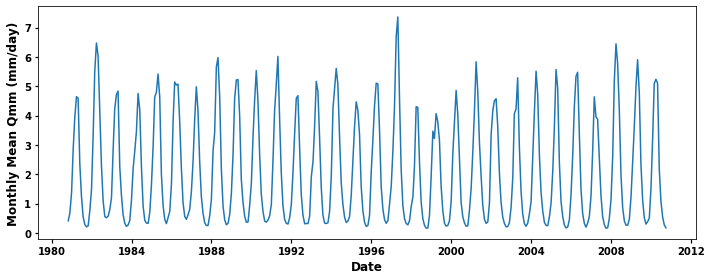

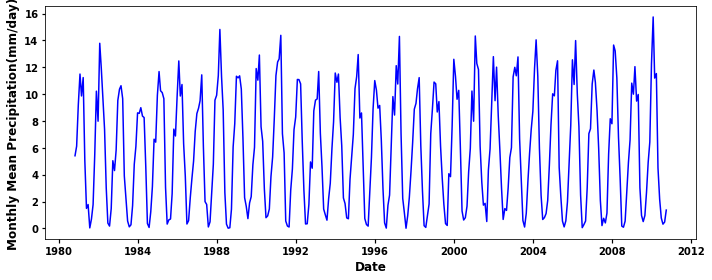

In [6]:
### Catchment 31
BASIN = 31
df31 = df[df[ID_COL] == BASIN].sort_values("date").copy()

# Monthly Trends (Streamflow & Precipitation)
m31 = df31.set_index("date")[[c for c in [TARGET, "prec_ref"] if c in df31.columns]].resample("M").mean()

plt.figure(figsize=(10, 4))
plt.plot(m31.index, m31[TARGET], label=TARGET)
plt.xlabel("Date", fontsize=12, fontweight="bold")
plt.ylabel("Monthly Mean Qmm (mm/day)")  
#plt.title(f"ID={BASIN} Monthly Mean {TARGET} ", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.savefig(os.path.join(GLOBAL_OUTPUT_DIR, "plots", "single_basin_ID31", "ts_monthly_Qmm_id31.png"))
plt.show()

if "prec_ref" in m31.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(m31.index, m31["prec_ref"], label="prec_ref", color="blue")
    plt.xlabel("Date", fontsize=12, fontweight="bold")
    plt.ylabel("Monthly Mean Precipitation(mm/day)", fontsize=12, fontweight="bold")  
    #plt.title(f"ID={BASIN} Monthly Mean Precipitation", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.savefig(os.path.join(GLOBAL_OUTPUT_DIR, "plots", "single_basin_ID31", "ts_monthly_prec_id31.png"))
    plt.show()


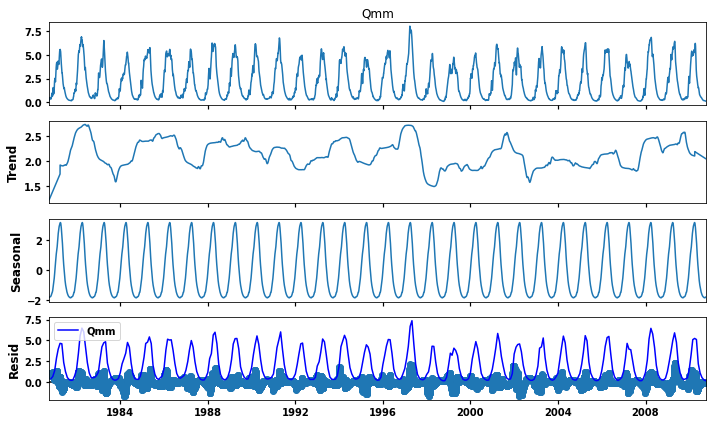

In [7]:
# Seasonal decomposition
s31 = df31.set_index("date")[TARGET].asfreq("D")
s31 = s31.interpolate(limit=7)
res = seasonal_decompose(s31, period=365, model="additive", extrapolate_trend="freq")
fig = res.plot()
fig.set_size_inches(10,6)
#plt.suptitle(f"Seasonal Decomposition of {TARGET} (ID={BASIN})", y=1.02, fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(GLOBAL_OUTPUT_DIR, "plots", "single_basin_ID31", "stl_Qmm_id31.png"))
plt.plot(m31.index, m31[TARGET], color='b', label='Qmm')
plt.legend()
plt.show()

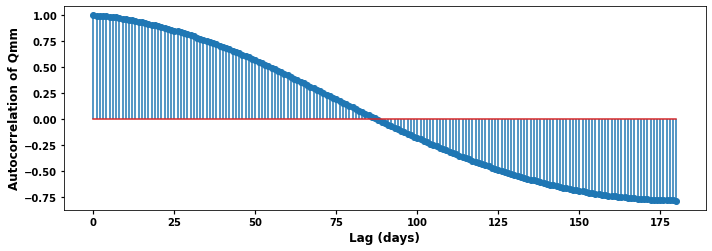

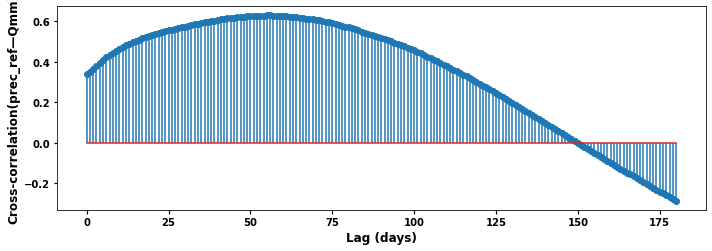

In [8]:
max_lag = 180

# catchment31 ACF/CCF 
def series_acf(s, max_lag):
    return [s.autocorr(lag=k) for k in range(max_lag+1)]

def cross_corr(x, y, max_lag):
    # y(t) vs x(t - lag)
    return [y.corr(x.shift(lag)) for lag in range(max_lag+1)]

acf_31 = series_acf(df31[TARGET], max_lag)
ccf_31 = cross_corr(df31["prec_ref"], df31[TARGET], max_lag) if "prec_ref" in df31.columns else None

plt.figure(figsize=(10,3.6))
plt.stem(range(max_lag+1), acf_31, use_line_collection=True)
plt.xlabel("Lag (days)"); plt.ylabel("Autocorrelation of Qmm")
#plt.title(f"ACF of {TARGET} (ID={BASIN})")
plt.tight_layout()
plt.savefig(os.path.join(GLOBAL_OUTPUT_DIR, "plots", "single_basin_ID31", "acf_id31.png"))
plt.show()

if ccf_31 is not None:
    plt.figure(figsize=(10,3.6))
    plt.stem(range(max_lag+1), ccf_31, use_line_collection=True)
    plt.xlabel("Lag (days)"); plt.ylabel("Cross-correlation(prec_ref—Qmm)")
    #plt.title(f"CCF (prec_ref lead) (ID={BASIN})")
    plt.tight_layout()
    plt.savefig(os.path.join(GLOBAL_OUTPUT_DIR, "plots", "single_basin_ID31", "ccf_id31.png"))
    plt.show()

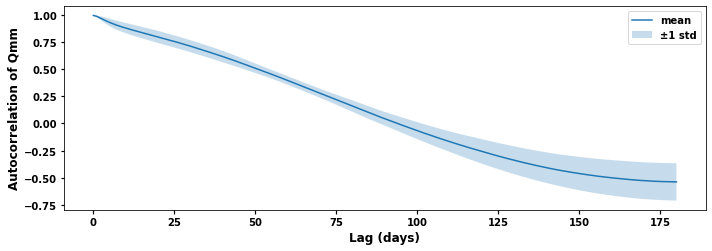

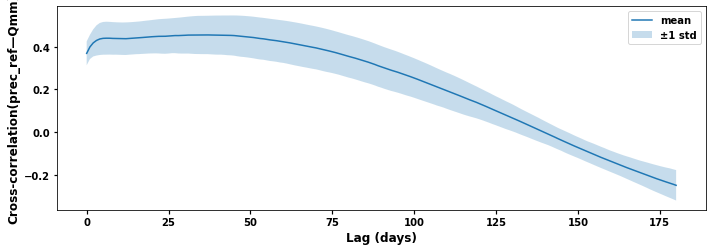

In [9]:
#all catchmnets ACF/CCF
acf_matrix, ccf_matrix = [], []
for b in BASIN_IDS:
    g = df[df[ID_COL]==b].sort_values("date")
    acf_vals = series_acf(g[TARGET], max_lag)
    acf_matrix.append(acf_vals)
    if "prec_ref" in g.columns:
        ccf_vals = cross_corr(g["prec_ref"], g[TARGET], max_lag)
        ccf_matrix.append(ccf_vals)

acf_mean, acf_std = np.nanmean(acf_matrix, axis=0), np.nanstd(acf_matrix, axis=0)

plt.figure(figsize=(10,3.6))
x = np.arange(max_lag+1)
plt.plot(x, acf_mean, label="mean")
plt.fill_between(x, acf_mean-acf_std, acf_mean+acf_std, alpha=0.25, label="±1 std")
plt.xlabel("Lag (days)"); plt.ylabel("Autocorrelation of Qmm")
#plt.title("Mean ACF across basins")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(GLOBAL_OUTPUT_DIR, "plots", "all_basins", "acf_mean_all.png"))
plt.show()

if len(ccf_matrix) > 0:
    ccf_mean, ccf_std = np.nanmean(ccf_matrix, axis=0), np.nanstd(ccf_matrix, axis=0)
    plt.figure(figsize=(10,3.6))
    plt.plot(x, ccf_mean, label="mean")
    plt.fill_between(x, ccf_mean-ccf_std, ccf_mean+ccf_std, alpha=0.25, label="±1 std")
    plt.xlabel("Lag (days)"); plt.ylabel("Cross-correlation(prec_ref—Qmm)")
    #plt.title("Mean CCF across basins")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(GLOBAL_OUTPUT_DIR, "plots", "all_basins", "ccf_mean_all.png"))
    plt.show()

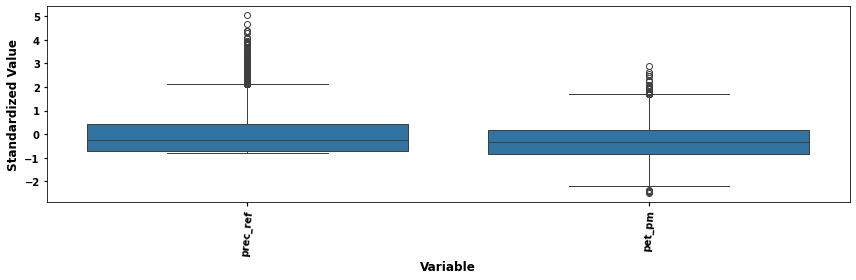

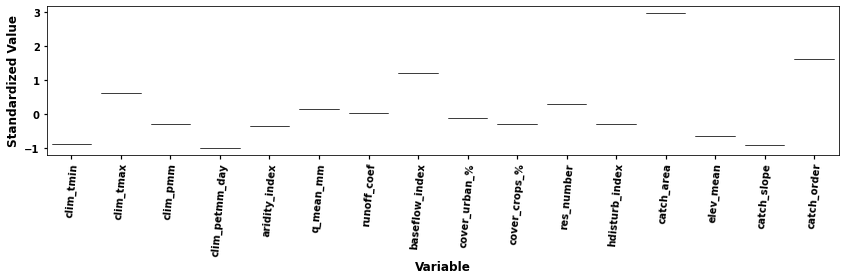

In [10]:
# DYNAMIC
dyn_cols = [c for c in ALL_DYNAMIC if c in df.columns]
sta_cols = [c for c in ALL_STATIC if c in df.columns]

dyn_scaler = StandardScaler().fit(df[dyn_cols].dropna()) if dyn_cols else None
sta_scaler = StandardScaler().fit(
    df[[ID_COL]+sta_cols].drop_duplicates(subset=ID_COL)[sta_cols]
) if sta_cols else None

df_vis = df.copy()
if dyn_scaler:
    df_vis[dyn_cols] = dyn_scaler.transform(df_vis[dyn_cols])
if sta_scaler:

    sta_unique = df[[ID_COL]+sta_cols].drop_duplicates(subset=ID_COL).copy()
    sta_unique[sta_cols] = sta_scaler.transform(sta_unique[sta_cols])
    df_vis = df_vis.drop(columns=sta_cols).merge(sta_unique, on=ID_COL, how="left")


def boxplot_cols(data, cols, title, fname):
    if not cols: return
    tmp = data[cols].melt(var_name="Variable", value_name="Standardized Value")
    plt.figure(figsize=(12,4))
    sns.boxplot(x="Variable", y="Standardized Value", data=tmp)
    plt.xticks(rotation=85)
    #plt.title(title)
    plt.tight_layout()
    plt.savefig(os.path.join(GLOBAL_OUTPUT_DIR, "plots", "single_basin_ID31", fname))
    plt.show()

boxplot_cols(df_vis[df_vis[ID_COL]==BASIN], dyn_cols, f"ID={BASIN} Dynamic Vars (std)", "box_dynamic_id31.png")
boxplot_cols(df_vis[df_vis[ID_COL]==BASIN], sta_cols, f"ID={BASIN} Static Vars (std)", "box_static_id31.png")

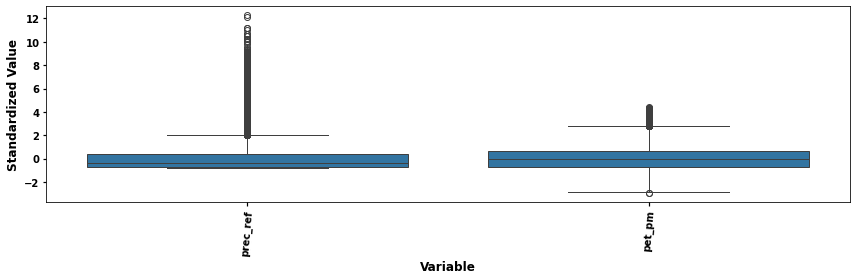

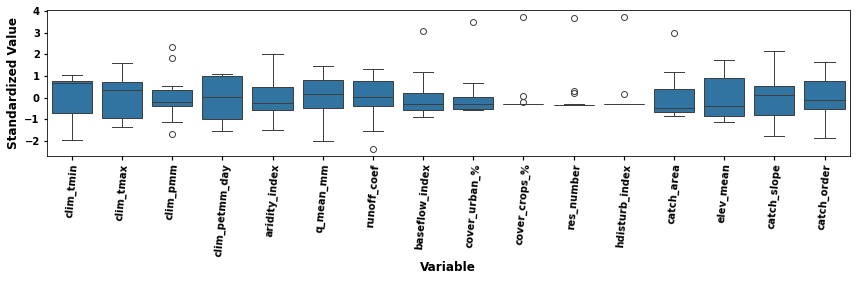

In [11]:
# --- 全流域箱线（动态/静态） ---
boxplot_cols(df_vis, dyn_cols, "All Basins Dynamic Vars (std)", "../all_basins/box_dynamic_all.png")
boxplot_cols(df_vis.drop_duplicates(subset=ID_COL), sta_cols, "All Basins Static Vars (std)", "../all_basins/box_static_all.png")

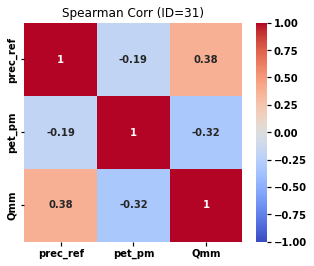

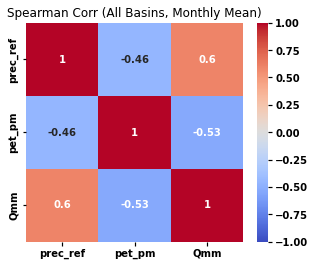

In [12]:
# Correlation Matrix: ID=31 (Dynamic+Target) 
corr_cols = [c for c in dyn_cols + [TARGET] if c in df.columns]
corr_31 = df31[corr_cols].corr(method="spearman")
plt.figure(figsize=(4.5,3.8))
sns.heatmap(corr_31, annot=True, vmin=-1, vmax=1, cmap="coolwarm")
plt.title(f"Spearman Corr (ID={BASIN})")
plt.tight_layout()
plt.savefig(os.path.join(GLOBAL_OUTPUT_DIR, "plots", "single_basin_ID31", "corr_dyn_target_id31.png"))
plt.show()

#Correlation matrix: all catchmnets (monthly average）
monthly = df.set_index("date")[corr_cols + [ID_COL]].groupby(ID_COL).resample("M").mean().reset_index(level=0, drop=True)
corr_all = monthly[corr_cols].corr(method="spearman")
plt.figure(figsize=(4.5,3.8))
sns.heatmap(corr_all, annot=True, vmin=-1, vmax=1, cmap="coolwarm")
plt.title("Spearman Corr (All Basins, Monthly Mean)")
plt.tight_layout()
plt.savefig(os.path.join(GLOBAL_OUTPUT_DIR, "plots", "all_basins", "corr_dyn_target_all_monthly.png"))
plt.show()

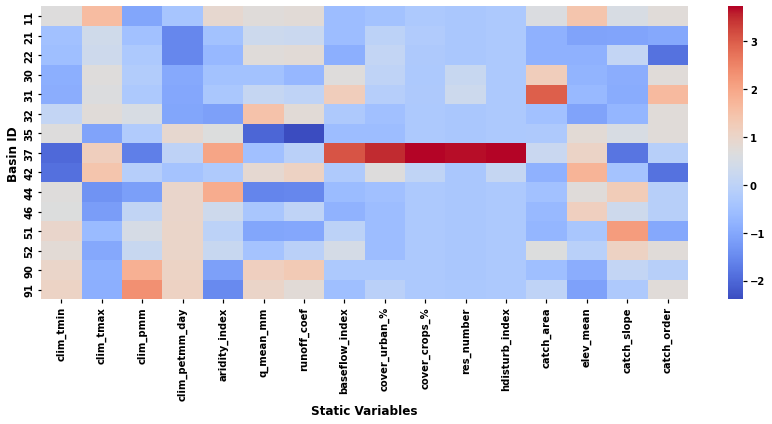

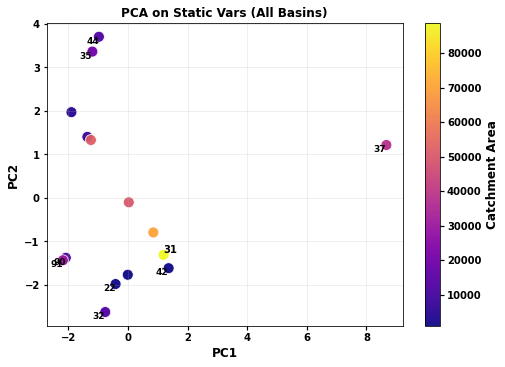

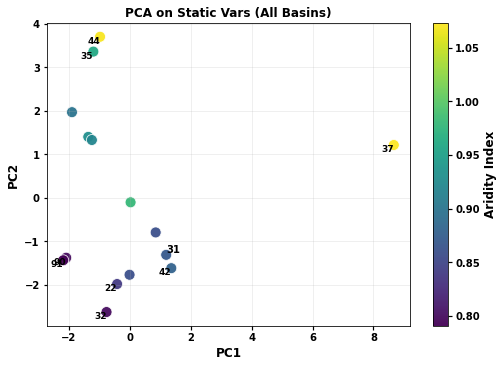

In [15]:
if sta_cols:
    sta_unique = df[[ID_COL]+sta_cols].drop_duplicates(subset=ID_COL).set_index(ID_COL)
    sta_scaled = pd.DataFrame(sta_scaler.transform(sta_unique), columns=sta_cols, index=sta_unique.index)

    # Static Vars Heatmap (scaled)
    plt.figure(figsize=(12,6))
    sns.heatmap(sta_scaled, cmap="coolwarm", cbar=True)
    plt.xlabel("Static Variables"); plt.ylabel("Basin ID")
    #plt.title("Static Vars Heatmap (scaled)")
    plt.tight_layout()
    plt.savefig(os.path.join(GLOBAL_OUTPUT_DIR, "plots", "all_basins", "static_heatmap_all.png"))
    plt.show()

    # PCA: Reduce to 2 dimensions and use static variables for similarity visualization
    pca = PCA(n_components=2, random_state=42)
    emb = pca.fit_transform(sta_scaled.values)
    df_pca = pd.DataFrame(emb, columns=["PC1","PC2"], index=sta_scaled.index).reset_index()
    df_pca.rename(columns={ID_COL: "BasinID"}, inplace=True)

    df_pca = df_pca.merge(
        df[[ID_COL, "catch_area", "aridity_index"]].drop_duplicates(ID_COL),
        left_on="BasinID", right_on=ID_COL
    )

    def plot_pca(df_pca, color_by, color_label, fname,
                 label_ids=(31,), annotate_extremes=True, cmap="viridis"):

        vals = df_pca[color_by].values
        vmin, vmax = np.percentile(vals, [5, 95])

        plt.figure(figsize=(7.2, 5.2))
        sc = plt.scatter(df_pca["PC1"], df_pca["PC2"],
                         c=df_pca[color_by], cmap=cmap, s=120, 
                         edgecolor="white", linewidth=0.8,     
                         vmin=vmin, vmax=vmax, alpha=0.95)
        cbar = plt.colorbar(sc)
        cbar.set_label(color_label, fontweight="bold")

        if label_ids:
            for bid in label_ids:
                row = df_pca[df_pca["BasinID"] == bid]
                if not row.empty:
                    plt.text(row["PC1"].values[0], row["PC2"].values[0],
                             str(int(bid)), fontsize=10, fontweight="bold",
                             ha="left", va="bottom")

        if annotate_extremes and len(df_pca) >= 6:
            extreme_rows = pd.concat([
                df_pca.nlargest(2, "PC1"), df_pca.nsmallest(2, "PC1"),
                df_pca.nlargest(2, "PC2"), df_pca.nsmallest(2, "PC2")
            ]).drop_duplicates(subset="BasinID")
            for _, r in extreme_rows.iterrows():
                plt.text(r["PC1"], r["PC2"], str(int(r["BasinID"])),
                         fontsize=9, fontweight="bold", ha="right", va="top")

        plt.xlabel("PC1", fontweight="bold"); plt.ylabel("PC2", fontweight="bold")
        plt.title("PCA on Static Vars (All Basins)", fontweight="bold")
        plt.grid(True, alpha=0.25)
        plt.tight_layout()
        outdir = os.path.join(GLOBAL_OUTPUT_DIR, "plots", "all_basins")
        os.makedirs(outdir, exist_ok=True)
        plt.savefig(os.path.join(outdir, fname), dpi=300, bbox_inches="tight")
        plt.show()

    plot_pca(df_pca, color_by="catch_area", color_label="Catchment Area",
             fname="static_pca_color_order.png", cmap="plasma", label_ids=(31,))
    plot_pca(df_pca, color_by="aridity_index",   color_label="Aridity Index",
             fname="static_pca_color_aridity.png", cmap="viridis", label_ids=(31,))

    df_pca[["BasinID", "PC1", "PC2", "catch_area", "aridity_index"]].to_csv(
        os.path.join(GLOBAL_OUTPUT_DIR, "tables", "04_static_pca_coords.csv"), index=False
    )

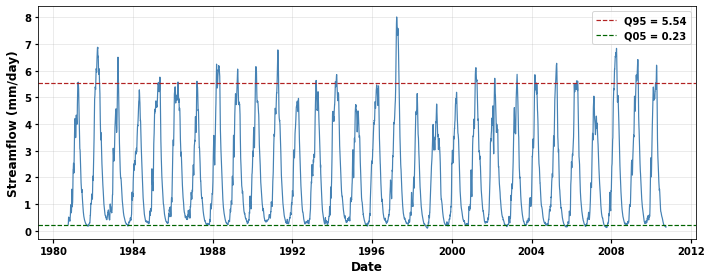

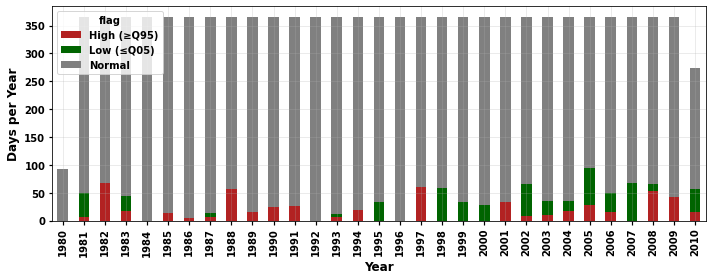

In [17]:
# Q95/Q05 
q95, q05 = df31[TARGET].quantile([0.95, 0.05])

df31_ext = df31[["date", TARGET]].copy()
df31_ext["flag"] = np.where(df31_ext[TARGET] >= q95, "High (≥Q95)",
                            np.where(df31_ext[TARGET] <= q05, "Low (≤Q05)", "Normal"))

#Count the number of extreme event days each year
df31_ext["Year"] = df31_ext["date"].dt.year
annual_ext = df31_ext.groupby(["Year", "flag"]).size().unstack(fill_value=0).reset_index()

# plot
plt.figure(figsize=(10,4))
plt.plot(df31["date"], df31[TARGET], color="steelblue", linewidth=1.2)
plt.axhline(q95, color="firebrick", linestyle="--", linewidth=1.2, label=f"Q95 = {q95:.2f}")
plt.axhline(q05, color="darkgreen", linestyle="--", linewidth=1.2, label=f"Q05 = {q05:.2f}")
plt.xlabel("Date", fontweight="bold")
plt.ylabel("Streamflow (mm/day)", fontweight="bold")
#plt.title(f"ID={BASIN} Extreme Flow Thresholds (Q95/Q05)", fontweight="bold")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(GLOBAL_OUTPUT_DIR, "plots", "single_basin_ID31", "ext_threshold_id31_paper.png"), dpi=300)
plt.show()

#plot
annual_ext.plot(x="Year", kind="bar", stacked=True, color=["firebrick", "darkgreen", "gray"], figsize=(10,4))
plt.xlabel("Year", fontweight="bold")
plt.ylabel("Days per Year", fontweight="bold")
#plt.title(f"ID={BASIN} Annual Extreme Flow Events", fontweight="bold")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(GLOBAL_OUTPUT_DIR, "plots", "single_basin_ID31", "ext_days_id31_paper.png"), dpi=300)
plt.show()

annual_ext.to_csv(os.path.join(GLOBAL_OUTPUT_DIR, "tables", "extreme_days_id31.csv"), index=False)


In [18]:
LOOKBACK = 60

DATE_TRAIN = ("1980-10-01", "1998-09-30")

df31_train = df31[(df31["date"]>=DATE_TRAIN[0]) & (df31["date"]<=DATE_TRAIN[1])].copy()

df31_vis_all = df31_train.copy()


if dyn_scaler:
    use_dyn_all = [c for c in ALL_DYNAMIC if c in df31_vis_all.columns]
    if use_dyn_all:
        df31_vis_all[use_dyn_all] = dyn_scaler.transform(df31_vis_all[use_dyn_all])


use_sta_all = [c for c in ALL_STATIC if c in df31_vis_all.columns]
if sta_scaler and use_sta_all:
    one_full = df31_train[ALL_STATIC].iloc[[0]].copy()  
    one_scaled_full = pd.DataFrame(sta_scaler.transform(one_full),
                                   columns=ALL_STATIC, index=one_full.index)
    df31_vis_all[ALL_STATIC] = np.repeat(one_scaled_full[ALL_STATIC].values,
                                         len(df31_vis_all), axis=0)

start_i = 0
window_all = df31_vis_all[ALL_FEATURES].iloc[start_i:start_i+LOOKBACK]  # (60, 18)


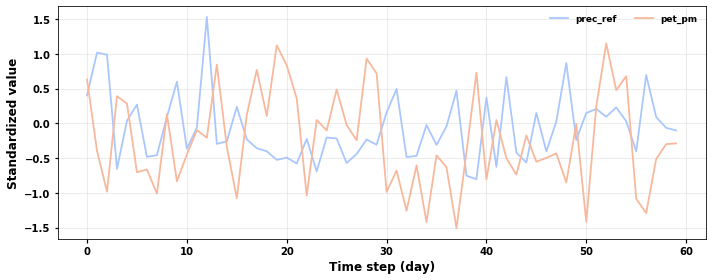

In [19]:
#ALL_DYNAMIC
dyn_colors = sns.color_palette("coolwarm", len(ALL_DYNAMIC))

plt.figure(figsize=(10,4))
for i, f in enumerate(ALL_DYNAMIC):
    plt.plot(range(LOOKBACK), window_all[f].values, label=f,
             linewidth=1.8, color=dyn_colors[i])
plt.xlabel("Time step (day)", fontsize=12, fontweight="bold")
plt.ylabel("Standardized value", fontsize=12, fontweight="bold")
#plt.title(f"Sliding Window – Dynamic vars (lookback={LOOKBACK}, ID={BASIN})",fontsize=12, fontweight="bold")
plt.xticks(fontsize=10, fontweight="bold"); plt.yticks(fontsize=10, fontweight="bold")
plt.grid(True, alpha=0.3)
plt.legend(ncol=2, fontsize=9, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(GLOBAL_OUTPUT_DIR, "plots", "single_basin_ID31",
                         f"sliding_window_DYNAMIC_all_lb{LOOKBACK}_id{BASIN}.png"),
            dpi=300, bbox_inches="tight")
plt.show()


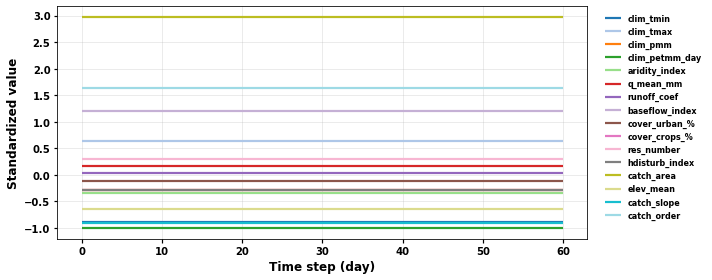

In [20]:
#ALL_STATIC
sta_palette = plt.cm.get_cmap("tab20", len(ALL_STATIC))


plt.figure(figsize=(10,4))
for i, f in enumerate(ALL_STATIC):
    y = window_all[f].values[0]  
    plt.hlines(y=y, xmin=0, xmax=LOOKBACK, linewidth=2.2,
               label=f, color=sta_palette(i))
plt.xlabel("Time step (day)", fontsize=12, fontweight="bold")
plt.ylabel("Standardized value", fontsize=12, fontweight="bold")
#plt.title(f"Sliding Window – Static vars (lookback={LOOKBACK}, ID={BASIN})",fontsize=12, fontweight="bold")
plt.xticks(fontsize=10, fontweight="bold"); plt.yticks(fontsize=10, fontweight="bold")
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8, frameon=False, ncol=1)
plt.tight_layout()
plt.savefig(os.path.join(GLOBAL_OUTPUT_DIR, "plots", "single_basin_ID31",
                         f"sliding_window_STATIC_all_lb{LOOKBACK}_id{BASIN}.png"),
            dpi=300, bbox_inches="tight")
plt.show()
